In [8]:
%pip install ipympl
%pip install reportlab>=3.6.2


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Imports
import base64
import re
from tempfile import TemporaryDirectory
from math import atan, cos, sin
from typing import Dict, Optional, Tuple
from xml.etree import ElementTree as ET
from xml.etree.ElementTree import Element

import numpy as np

from doctr.io import DocumentFile
from doctr.models import ocr_predictor
from PIL import Image
from reportlab.lib.colors import black
from reportlab.lib.units import inch
from reportlab.lib.utils import ImageReader
from reportlab.pdfgen.canvas import Canvas

In [1]:
import os
os.environ['USE_TORCH'] = '1'
import matplotlib.pyplot as plt
from pathlib import Path
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

In [11]:
class HocrParser():

    def __init__(self):
        self.box_pattern = re.compile(r'bbox((\s+\d+){4})')
        self.baseline_pattern = re.compile(r'baseline((\s+[\d\.\-]+){2})')

    def _element_coordinates(self, element: Element) -> Dict:
        """
        Returns a tuple containing the coordinates of the bounding box around
        an element
        """
        out = out = {'x1': 0, 'y1': 0, 'x2': 0, 'y2': 0}
        if 'title' in element.attrib:
            matches = self.box_pattern.search(element.attrib['title'])
            if matches:
                coords = matches.group(1).split()
                out = {'x1': int(coords[0]), 'y1': int(
                    coords[1]), 'x2': int(coords[2]), 'y2': int(coords[3])}
        return out

    def _get_baseline(self, element: Element) -> Tuple[float, float]:
        """
        Returns a tuple containing the baseline slope and intercept.
        """
        if 'title' in element.attrib:
            matches = self.baseline_pattern.search(
                element.attrib['title']).group(1).split()
            if matches:
                return float(matches[0]), float(matches[1])
        return (0.0, 0.0)

    def _pt_from_pixel(self, pxl: Dict, dpi: int) -> Dict:
        """
        Returns the quantity in PDF units (pt) given quantity in pixels
        """
        pt = [(c / dpi * inch) for c in pxl.values()]
        return {'x1': pt[0], 'y1': pt[1], 'x2': pt[2], 'y2': pt[3]}

    def _get_element_text(self, element: Element) -> str:
        """
        Return the textual content of the element and its children
        """
        text = ''
        if element.text is not None:
            text += element.text
        for child in element:
            text += self._get_element_text(child)
        if element.tail is not None:
            text += element.tail
        return text

    def export_pdfa(self,
                    out_filename: str,
                    hocr: ET.ElementTree,
                    image: Optional[np.ndarray] = None,
                    fontname: str = "Times-Roman",
                    fontsize: int = 12,
                    invisible_text: bool = True,
                    add_spaces: bool = True,
                    dpi: int = 300):
        """
        Generates a PDF/A document from a hOCR document.
        """

        width, height = None, None
        # Get the image dimensions
        for div in hocr.findall(".//div[@class='ocr_page']"):
            coords = self._element_coordinates(div)
            pt_coords = self._pt_from_pixel(coords, dpi)
            width, height = pt_coords['x2'] - \
                pt_coords['x1'], pt_coords['y2'] - pt_coords['y1']
            # after catch break loop
            break
        if width is None or height is None:
            raise ValueError("Could not determine page size")

        pdf = Canvas(out_filename, pagesize=(width, height), pageCompression=1)

        span_elements = [element for element in hocr.iterfind(".//span")]
        for line in span_elements:
            if 'class' in line.attrib and line.attrib['class'] == 'ocr_line' and line is not None:
                # get information from xml
                pxl_line_coords = self._element_coordinates(line)
                line_box = self._pt_from_pixel(pxl_line_coords, dpi)

                # compute baseline
                slope, pxl_intercept = self._get_baseline(line)
                if abs(slope) < 0.005:
                    slope = 0.0
                angle = atan(slope)
                cos_a, sin_a = cos(angle), sin(angle)
                intercept = pxl_intercept / dpi * inch
                baseline_y2 = height - (line_box['y2'] + intercept)

                # configure options
                text = pdf.beginText()
                text.setFont(fontname, fontsize)
                pdf.setFillColor(black)
                if invisible_text:
                    text.setTextRenderMode(3)  # invisible text

                # transform overlayed text
                text.setTextTransform(
                    cos_a, -sin_a, sin_a, cos_a, line_box['x1'], baseline_y2)

                elements = line.findall(".//span[@class='ocrx_word']")
                for elem in elements:
                    elemtxt = self._get_element_text(elem).strip()
                    # replace unsupported characters
                    elemtxt = elemtxt.translate(str.maketrans(
                        {'ﬀ': 'ff', 'ﬃ': 'f‌f‌i', 'ﬄ': 'f‌f‌l', 'ﬁ': 'fi', 'ﬂ': 'fl'}))
                    if not elemtxt:
                        continue

                    # compute string width
                    pxl_coords = self._element_coordinates(elem)
                    box = self._pt_from_pixel(pxl_coords, dpi)
                    if add_spaces:
                        elemtxt += ' '
                        box_width = box['x2'] + pdf.stringWidth(elemtxt, fontname, fontsize) - box['x1']
                    else:
                        box_width = box['x2'] - box['x1']
                    font_width = pdf.stringWidth(elemtxt, fontname, fontsize)

                    # Adjust relative position of cursor
                    cursor = text.getStartOfLine()
                    dx = box['x1'] - cursor[0]
                    dy = baseline_y2 - cursor[1]
                    text.moveCursor(dx, dy)

                    # suppress text if it is 0 units wide
                    if font_width > 0:
                        text.setHorizScale(100 * box_width / font_width)
                        text.textOut(elemtxt)
                pdf.drawText(text)

        # overlay image if provided
        if image is not None:
            pdf.drawImage(ImageReader(Image.fromarray(image)),
                          0, 0, width=width, height=height)
        pdf.save()

In [2]:
new_ocr_pdf_path  = Path('amendments/New_Exhibit_Redacted_OCR_new.pdf')
new_orig_pdf_path = Path('amendments/New_Exhibit_Redacted.pdf')
old_ocr_pdf_path  = Path('amendments/Old_Exhibit_Redacted_OCR_new.pdf')
old_orig_pdf_path = Path('amendments/Old_Exhibit_Redacted.pdf')

In [3]:
doc = DocumentFile.from_pdf(old_orig_pdf_path)
print(f"Number of pages: {len(doc)}")


Number of pages: 2


In [4]:
# Instantiate a pretrained model
predictor = ocr_predictor(pretrained=True)
# Display the architecture
print(predictor)

OCRPredictor(
  (det_predictor): DetectionPredictor(
    (pre_processor): PreProcessor(
      (resize): Resize(output_size=(1024, 1024), interpolation='bilinear', preserve_aspect_ratio=True, symmetric_pad=True)
      (normalize): Normalize(mean=(0.798, 0.785, 0.772), std=(0.264, 0.2749, 0.287))
    )
    (model): FAST()
  )
  (reco_predictor): RecognitionPredictor(
    (pre_processor): PreProcessor(
      (resize): Resize(output_size=(32, 128), interpolation='bilinear', preserve_aspect_ratio=True, symmetric_pad=False)
      (normalize): Normalize(mean=(0.694, 0.695, 0.693), std=(0.299, 0.296, 0.301))
    )
    (model): CRNN(
      (feat_extractor): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=

In [5]:
result = predictor(doc)

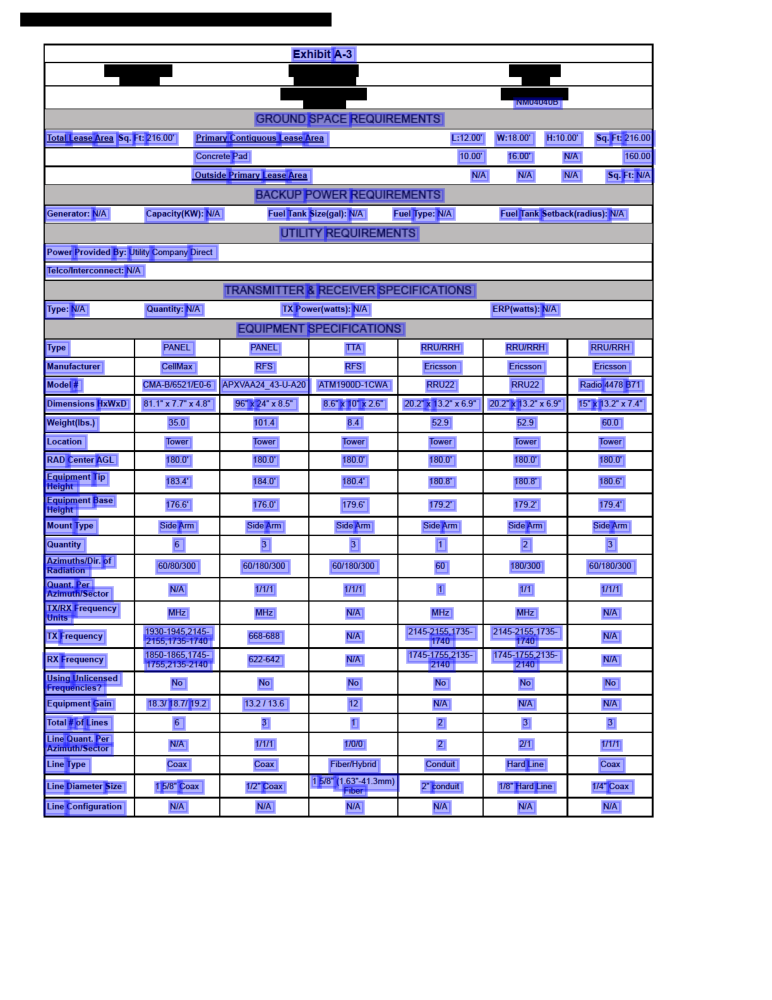

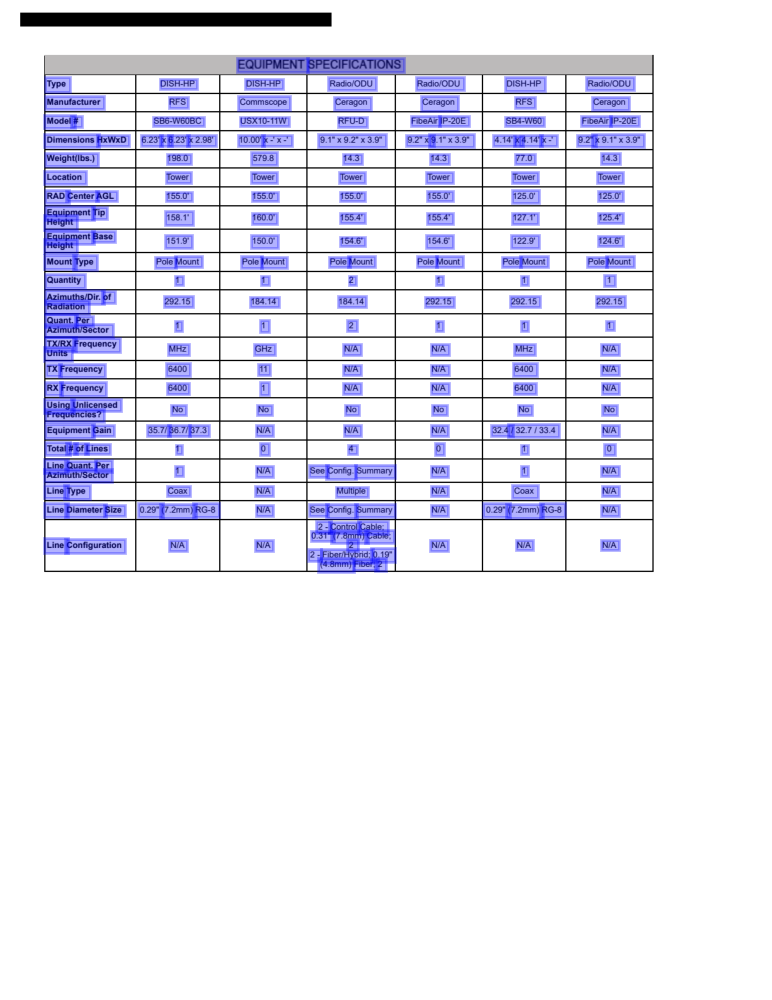

In [6]:
%matplotlib widget
result.show()

In [ ]:
plt.imshow

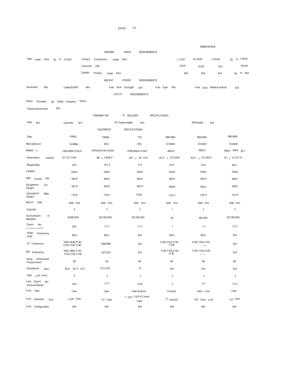

In [17]:
synthetic_pages = result.synthesize()
fig,ax = plt.subplots(); ax.imshow(synthetic_pages[0]); ax.axis('off'); plt.show(); fig.savefig(old_orig_pdf_path.with_suffix('.png'),dpi=1000)

In [13]:

# returns: list of tuple where the first element is the (bytes) xml string and the second is the ElementTree
xml_outputs = result.export_as_xml()

# init the above parser
parser = HocrParser()

# iterate through the xml outputs and images and export to pdf/a
# the image is optional else you can set invisible_text=False and the text will be printed on a blank page
for i, (xml, img) in enumerate(zip(xml_outputs, doc)):
    xml_element_tree = xml[1]
    parser.export_pdfa(f'{i}.pdf', hocr=xml_element_tree, image=img)